In [ ]:
# Exploring the communities and crime data set from the UCI repository.
# We are trying to predict whether the level of violent crime in a community is
# above 0.2.  The crime level is a value that represents the
# number of violent crimes per capita, normalized to fit the interval [0,1]. 
# Download communities.data from
# http://archive.ics.uci.edu/ml/machine-learning-databases/communities/

%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import print_function
import pandas as pd
import ipywidgets as widgets
import numpy as np
import communities
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from forest_clusters import ForestClusters, buckets, total_variation

original_data = communities.data
original_data = original_data[original_data.columns.difference(['fold'])]
original_data = original_data[original_data.columns.difference(communities.uninformative)]
def extract_features(original_data):
    exclude = communities.uninformative + \
              communities.race_features + \
              ['ViolentCrimesPerPop']
    return original_data[original_data.columns.difference(exclude)].fillna(-1)
X = extract_features(original_data)
y = original_data['ViolentCrimesPerPop'] >= 0.2
def present_features(original_data):
    return original_data.fillna(-1)

In [1]:
original_train, original_test, X_train, X_test, y_train, y_test = train_test_split(original_data, X, y, train_size=0.70)

forest = RandomForestClassifier(n_estimators=30, max_depth = 10, min_samples_leaf = 30)
forest = forest.fit(X_train, y_train)
print("Random forest train accuracy: %f" % forest.score(X_train, y_train))
print("Random forest test accuracy: %f" % forest.score(X_test, y_test))

Random forest train accuracy: 0.855914
Random forest test accuracy: 0.853088


/home/arthur/env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [21]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators = 50, max_depth = 1, min_samples_leaf = 100)
model = model.fit(X_train, y_train)
print("Mean", y.mean())
print("Train", model.score(X_train, y_train))
print("Test", model.score(X_test, y_test))

Mean 0.4237713139418255
Train 0.8415770609318997
Test 0.8564273789649416


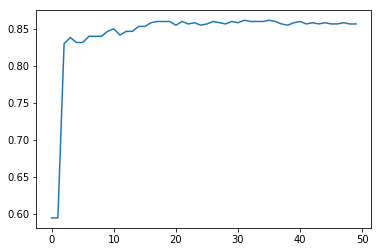

In [22]:
points = []
for f in model.staged_predict(X_test):
    points += [(f == y_test).mean()]
plt.plot(points)

In [23]:
import math
tests = {}

for e in model.estimators_[:,0]:
    feature = X.columns[e.tree_.feature[0]]
    threshold = e.tree_.threshold[0]
    if not feature in tests:
        tests[feature] = {}
    if not threshold in tests[feature]:
        tests[feature][threshold] = np.array([0.0, 0.0])
    tests[feature][threshold] += e.tree_.value[1:,0,0]
    
tests
tests_c = {feature: set(thresholds.keys())
           for feature, thresholds in tests.items()}
tests_c

{'FemalePctDiv': {0.4050000011920929},
 'HousVacant': {0.04500000178813934},
 'NumIlleg': {0.014999999664723873, 0.02499999850988388},
 'NumImmig': {0.02499999850988388, 0.04500000178813934},
 'NumStreet': {0.004999999888241291},
 'PctBSorMore': {0.375},
 'PctBornSameState': {0.29500001668930054},
 'PctFam2Par': {0.5349999666213989},
 'PctIlleg': {0.2150000035762787, 0.2549999952316284, 0.375},
 'PctKids2Par': {0.5149999856948853,
  0.6150000095367432,
  0.625,
  0.6449999809265137,
  0.7150000333786011,
  0.7350000143051147,
  0.7450000047683716},
 'PctPersDenseHous': {0.125, 0.1850000023841858, 0.19499999284744263},
 'PctSpeakEnglOnly': {0.6349999904632568},
 'TotalPctDiv': {0.48500001430511475, 0.5149999856948853},
 'pctWInvInc': {0.42500001192092896}}

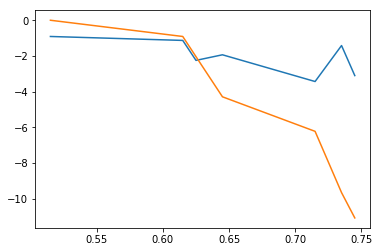

In [25]:
import math 
feature = 'PctKids2Par'
thresholds = [t for t in list(tests[feature].keys())]
thresholds.sort()
coefs = np.zeros(len(thresholds) + 1, dtype=float)
for i in range(len(thresholds)):
    for threshold in thresholds:
        if thresholds[i] <= threshold:
            coefs[i] += tests[feature][threshold][0]
        else:
            coefs[i] += tests[feature][threshold][1]
            
for threshold in thresholds:
    coefs[len(thresholds)] += tests[feature][threshold][1]
    
for i in range(1, len(coefs)):
    coefs[i] -= coefs[0]
coefs[0] = 0.0
diffs = np.zeros(len(thresholds) + 1)
diffs[0] = coefs[0]
for i in range(len(thresholds)):
    diffs[i + 1] = coefs[i + 1] - coefs[i]
    
plt.plot(thresholds, diffs[1:])
plt.plot(thresholds, coefs[0:-1])

In [26]:
selected = {}
weird = {}

for feature, thresholds in tests_c.items():
    ts = list(thresholds)
    ts.sort()
    if len(ts) > 1:
        if feature in ['Capital Gain', 'Capital Loss']:
            weird[feature] = np.zeros(len(X), dtype=bool)
            keep = []
            for i in range(len(ts)):
                lb = float('-inf') if i == 0 else ts[i - 1]
                ub = ts[i]
                mask = X[feature].between(lb, ub)
                if y[mask].any() or True:
                    keep = keep + [ub]
                else:
                    weird[feature] |= mask
            selected[feature] = set(keep)
        else:
            selected[feature] = set(ts)
    else:
        selected[feature] = set(ts)
        
selected

{'FemalePctDiv': {0.4050000011920929},
 'HousVacant': {0.04500000178813934},
 'NumIlleg': {0.014999999664723873, 0.02499999850988388},
 'NumImmig': {0.02499999850988388, 0.04500000178813934},
 'NumStreet': {0.004999999888241291},
 'PctBSorMore': {0.375},
 'PctBornSameState': {0.29500001668930054},
 'PctFam2Par': {0.5349999666213989},
 'PctIlleg': {0.2150000035762787, 0.2549999952316284, 0.375},
 'PctKids2Par': {0.5149999856948853,
  0.6150000095367432,
  0.625,
  0.6449999809265137,
  0.7150000333786011,
  0.7350000143051147,
  0.7450000047683716},
 'PctPersDenseHous': {0.125, 0.1850000023841858, 0.19499999284744263},
 'PctSpeakEnglOnly': {0.6349999904632568},
 'TotalPctDiv': {0.48500001430511475, 0.5149999856948853},
 'pctWInvInc': {0.42500001192092896}}

In [27]:
X_proj = {}

for feature, thresholds in selected.items():
    thresholds = list(thresholds)
    thresholds.sort()
    if len(thresholds) > 1:
        for i in range(len(thresholds)):
            key = feature + ("_%2d_%.1f" % (i, thresholds[i]))
            mask = X[feature] > thresholds[i]
            # if feature in ['Capital Gain', 'Capital Loss']:
            #     mask = mask * (~ weird[feature])
            X_proj[key] = mask
        X_proj[key + ">"] = X[feature] <= thresholds[i]
    else:
        X_proj[feature] = X[feature] > thresholds[0]
        
X_proj = pd.DataFrame(X_proj)
# X_proj = X_proj[X_proj.columns.difference(rem)]
X_proj

,FemalePctDiv,HousVacant,NumIlleg_ 0_0.0,NumIlleg_ 1_0.0,NumIlleg_ 1_0.0>,NumImmig_ 0_0.0,NumImmig_ 1_0.0,NumImmig_ 1_0.0>,NumStreet,PctBSorMore,...,PctKids2Par_ 6_0.7>,PctPersDenseHous_ 0_0.1,PctPersDenseHous_ 1_0.2,PctPersDenseHous_ 2_0.2,PctPersDenseHous_ 2_0.2>,PctSpeakEnglOnly,TotalPctDiv_ 0_0.5,TotalPctDiv_ 1_0.5,TotalPctDiv_ 1_0.5>,pctWInvInc
0,True,True,True,True,False,True,False,True,False,True,...,True,False,False,False,True,True,True,True,False,True
1,True,False,False,False,True,False,False,True,False,False,...,True,True,True,True,False,True,True,True,False,True
2,True,False,False,False,True,False,False,True,False,False,...,True,True,False,False,True,True,True,True,False,False
3,True,False,True,True,False,False,False,True,False,False,...,True,False,False,False,True,True,False,False,True,True
4,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,True,True,False,False,True,True
5,True,False,False,False,True,True,False,True,False,True,...,True,True,True,True,False,False,True,True,False,True
6,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,True,True,False,False,True,True
7,True,False,True,False,True,False,False,True,False,False,...,True,True,True,True,False,False,True,True,False,False
8,True,False,True,False,True,False,False,True,False,False,...,True,False,False,False,True,True,True,True,False,False
9,False,False,False,False,True,False,False,True,False,True,...,True,False,False,False,True,True,False,False,True,True


In [28]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

iterations = 20
scores_train = np.zeros(iterations, dtype=float)
scores_test = np.zeros(iterations, dtype=float)
y_proj = y
for i in range(iterations):
    X_proj_train, X_proj_test, y_train, y_test = train_test_split(X_proj, y_proj, train_size = 0.9)
    logrel = LogisticRegression(C = 1.5, solver = 'sag').fit(X_proj_train, y_train)
    # logrel = SGDClassifier().fit(X_proj_train, y_train)
    scores_train[i] = logrel.score(X_proj_train, y_train)
    scores_test[i] = logrel.score(X_proj_test, y_test)
    print('Train', i, scores_train[i])
    print('Test', i, scores_test[i])

print('Train mean', scores_train.mean())
print('Train deviation', scores_train.std())
print('Test mean', scores_test.mean())
print('Test deviation', scores_test.std())

/home/arthur/env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/arthur/env/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train 0 0.8584169453734671
Test 0 0.88
Train 1 0.8589743589743589
Test 1 0.84
Train 2 0.8567447045707915
Test 2 0.875
Train 3 0.862876254180602
Test 3 0.835
Train 4 0.8634336677814939
Test 4 0.855
Train 5 0.8539576365663322
Test 5 0.88
Train 6 0.8617614269788183
Test 6 0.835
Train 7 0.8567447045707915
Test 7 0.845
Train 8 0.8584169453734671
Test 8 0.84
Train 9 0.8617614269788183
Test 9 0.835
Train 10 0.8528428093645485
Test 10 0.9
Train 11 0.8573021181716833
Test 11 0.855
Train 12 0.855072463768116
Test 12 0.875
Train 13 0.862876254180602
Test 13 0.855
Train 14 0.8567447045707915
Test 14 0.86
Train 15 0.8600891861761427
Test 15 0.85
Train 16 0.8600891861761427
Test 16 0.85
Train 17 0.8567447045707915
Test 17 0.845
Train 18 0.8600891861761427
Test 18 0.845
Train 19 0.8617614269788183
Test 19 0.83
Train mean 0.8588350055741362
Train deviation 0.0029855470018991894
Test mean 0.8542499999999998
Test deviation 0.01832177666057527


In [29]:
coefs_lin = dict(zip(X_proj.columns, list(logrel.coef_[0])))
coefs_lin

{'FemalePctDiv': 0.6794457324579991,
 'HousVacant': 0.5437926461008853,
 'NumIlleg_ 0_0.0': -0.2767443152428121,
 'NumIlleg_ 1_0.0': -0.09354263516154757,
 'NumIlleg_ 1_0.0>': 0.10036683622490306,
 'NumImmig_ 0_0.0': 0.5023918485430686,
 'NumImmig_ 1_0.0': 0.349041683850341,
 'NumImmig_ 1_0.0>': -0.3422174827869288,
 'NumStreet': 0.6766256989674437,
 'PctBSorMore': -0.5943872327632758,
 'PctBornSameState': -0.886135887261535,
 'PctFam2Par': -0.27365904354595605,
 'PctIlleg_ 0_0.2': 0.44713532830556774,
 'PctIlleg_ 1_0.3': 0.6915591817794997,
 'PctIlleg_ 2_0.4': 0.5552613986550379,
 'PctIlleg_ 2_0.4>': -0.5484371975916577,
 'PctKids2Par_ 0_0.5': -0.2466303800334289,
 'PctKids2Par_ 1_0.6': -0.05705623628513306,
 'PctKids2Par_ 2_0.6': -0.35254009390166813,
 'PctKids2Par_ 3_0.6': 0.2245413943578831,
 'PctKids2Par_ 4_0.7': -0.4069009933895109,
 'PctKids2Par_ 5_0.7': -0.43041388087927845,
 'PctKids2Par_ 6_0.7': -0.26641466554089227,
 'PctKids2Par_ 6_0.7>': 0.27323886660429486,
 'PctPersDense

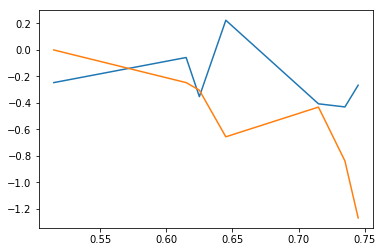

In [34]:
feature = 'PctKids2Par'

thresholds = list(selected[feature])
thresholds.sort()

diffs1 = np.array([coefs_lin[feature + ("_%2d_%.1f" % (i, thresholds[i]))] for i in range(len(thresholds))])
# diffs1 = np.array([sum(diffs2[:i]) for i in range(len(thresholds))])
vals   = np.array([sum(diffs1[:i]) for i in range(len(thresholds))])

# plt.plot(thresholds, diffs2)
plt.plot(thresholds, diffs1)
plt.plot(thresholds, vals)

In [35]:
ps = original_data
sel = ps[feature] <= thresholds[0]
print('High', thresholds[0], 'Size', sum(sel), y[sel].mean())
for i in range(len(thresholds) - 1):
    a = thresholds[i]
    b = thresholds[i + 1]
    sel = ps[feature].between(a, b)
    print('Low', a, 'High', b, 'Size', sum(sel), y[sel].mean())
sel = ps[feature] >= thresholds[-1]
print('Low', thresholds[-1], 'Size', sum(sel), y[sel].mean())

High 0.5149999856948853 Size 568 0.852112676056338
Low 0.5149999856948853 High 0.6150000095367432 Size 347 0.5936599423631124
Low 0.6150000095367432 High 0.625 Size 42 0.42857142857142855
Low 0.625 High 0.6449999809265137 Size 59 0.3728813559322034
Low 0.6449999809265137 High 0.7150000333786011 Size 241 0.2987551867219917
Low 0.7150000333786011 High 0.7350000143051147 Size 83 0.20481927710843373
Low 0.7350000143051147 High 0.7450000047683716 Size 37 0.13513513513513514
Low 0.7450000047683716 Size 617 0.03403565640194489


In [24]:
leaf_encoder = OneHotEncoder()
leaf_encoder = leaf_encoder.fit(forest.apply(X))

n_clusters = 20
clusters = KMeans(n_clusters = n_clusters)
clusters = clusters.fit(leaf_encoder.transform(forest.apply(X)))
clusters = clusters.predict(leaf_encoder.transform(forest.apply(X_test)))

KeyboardInterrupt: 

In [3]:
from display_cluster import display_cluster
display_cluster(forest, original_data, original_test, y_test,
                forest.apply(X_test), clusters, n_clusters,
                encode_features=extract_features,
                present_features=present_features,
                feature_description=communities.description)

,Size,Accuracy,Mean Votes
0,16,0.937500,0.989583
1,66,0.984848,0.000505
2,29,0.758621,0.119540
3,37,1.000000,0.995495
4,15,0.600000,0.844444
5,31,0.935484,0.068817
6,25,0.520000,0.606667
7,30,0.500000,0.388889
8,35,0.685714,0.763810
9,41,0.682927,0.482927


interactive(children=(BoundedIntText(value=0, description='Cluster', max=20), Dropdown(description='Column', o…

In [4]:
from display_cluster import CompressedForest
from sklearn.cluster import AgglomerativeClustering
cforest = CompressedForest(forest)
cleaf_encoder = OneHotEncoder().fit(cforest.apply(X))
X_leaves = cleaf_encoder.transform(cforest.apply(X))
n_cclusters = 8
cclusters = AgglomerativeClustering(n_clusters = n_cclusters, affinity = 'l1', linkage = 'average')
cclusters = cclusters.fit_predict(X_leaves.toarray())

In [5]:
display_cluster(forest, original_data, original_data, y,
                cforest.apply(X), cclusters, n_cclusters,
                encode_features=extract_features,
                present_features=present_features,
                feature_description=communities.description)

,Size,Accuracy,Mean Votes
0,1074,0.879888,0.070981
1,78,0.653846,0.370940
2,37,0.432432,0.502703
3,665,0.870677,0.893283
4,39,0.666667,0.679487
5,52,0.730769,0.611538
6,18,0.722222,0.562963
7,31,0.677419,0.563441


interactive(children=(BoundedIntText(value=0, description='Cluster', max=8), Dropdown(description='Column', op…

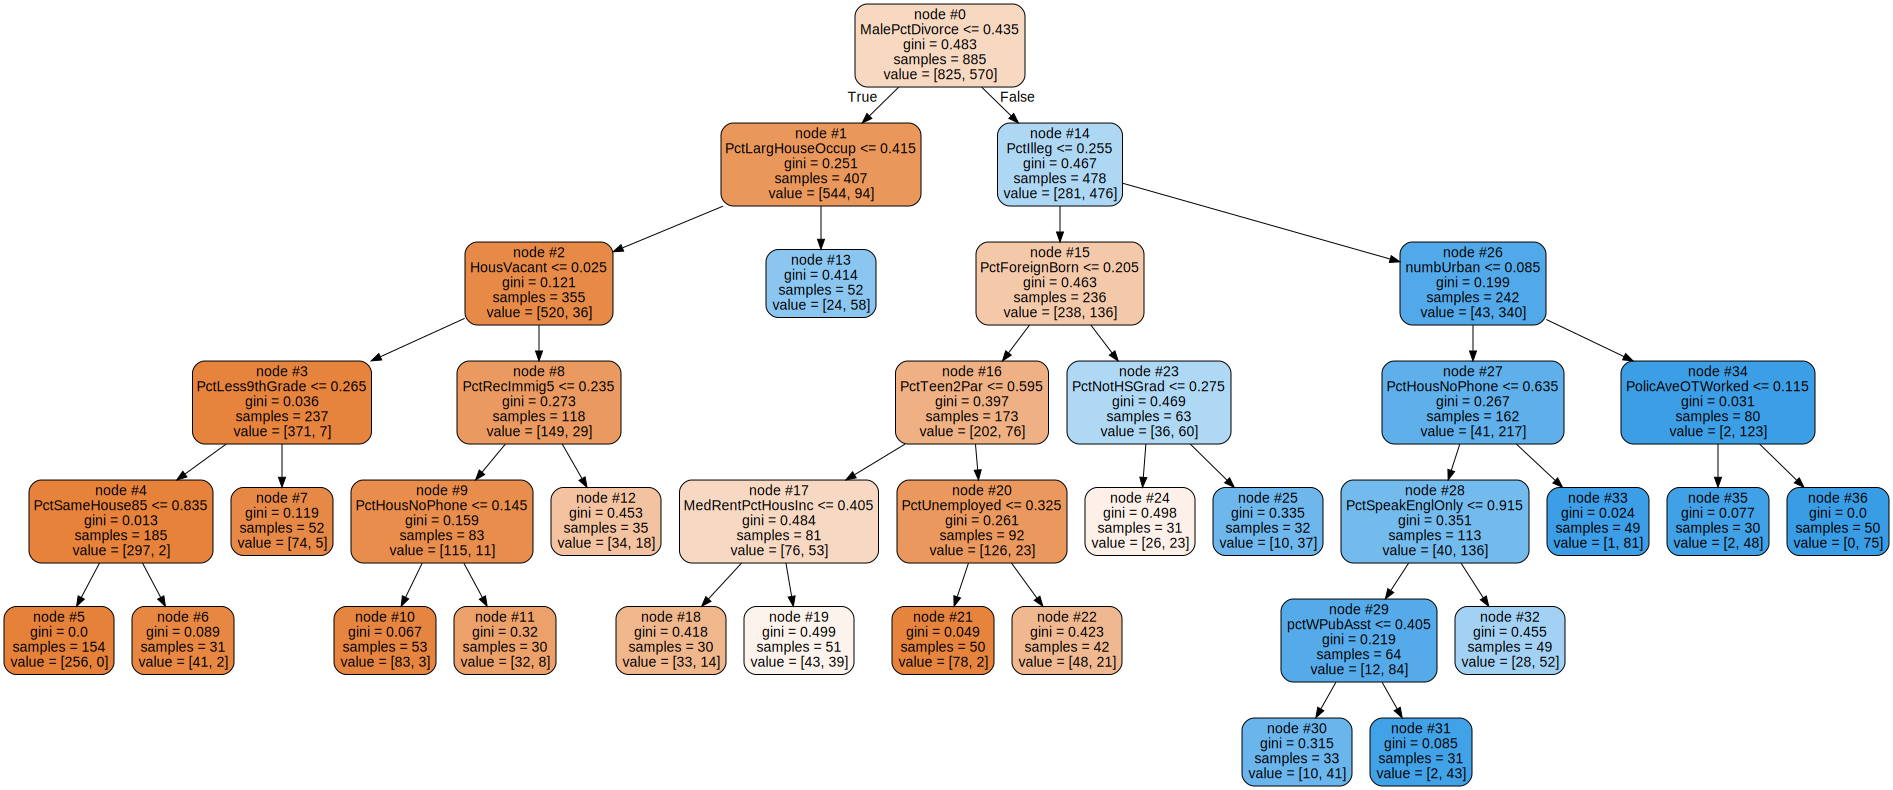

In [41]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(forest.estimators_[10
                                             ], 
                           feature_names = X_test.columns,
                           out_file = None, filled = True,
                           rounded = True, node_ids = True)
graph = graphviz.Source(dot_data)
graph